In [1]:
#import importlib
#importlib.reload(training)

In [2]:
#<module 'training' from '../../../../secondary_funcs/training.py'>

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
from pathlib import Path
import sys
sys.path.append('secondary_funcs/')

#from data_preparation import get_final_data
from result_analysis import get_scores
from copy import deepcopy
import training
from result_analysis import predictions_to_classes

In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [6]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from bayes_opt import BayesianOptimization

from wiseml.feature_engineering.wt_ohlc.wt_volatility import add_volatility

from wiseml.feature_engineering.ohlc import OHLCIndicatorsFeatureEngineer
from wiseml.validation.purged_k_fold import PurgedKFold

from wiseml.feature_engineering.wt_ohlc import add_volatility

## Data preparation

In [7]:
PATH_DATA = Path('../../../data/main_data/with_features/')

## Data loading

In [8]:
%%time
data = pd.read_csv('data_for_boosting.csv')

Wall time: 14.9 s


In [9]:
data.shape

(823422, 125)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823422 entries, 0 to 823421
Columns: 125 entries, volatility_atr to target
dtypes: float64(119), int64(5), object(1)
memory usage: 785.3+ MB


In [11]:
data.head()

,volatility_atr,volume_adi,momentum_tsi,momentum_rsi,momentum_stoch,momentum_wr,returns_lag_1,minute,"value__fft_coefficient__coeff_0__attr_""abs""",close_returns_log,...,"value__fft_coefficient__coeff_2__attr_""angle""","value__fft_coefficient__coeff_8__attr_""abs""",value__number_crossing_m__m_0,value__c3__lag_2,"value__fft_aggregated__aggtype_""variance""",returns_25,returns_16,returns_26,datetime,target
0,2.232631,-62.084025,1.334591,76.659155,96.774194,-3.225806,0.000282,11,0.000283,0.000000,...,162.231277,0.000309,26.0,-1.148034e-15,205.975487,0.001553,0.000470,0.001506,2019-07-21 05:11:34.542501,2
1,2.108871,-91.595042,2.166042,73.108003,93.548387,-6.451613,0.000000,11,0.000309,-0.000005,...,170.244199,0.000323,27.0,-1.255613e-15,210.047304,0.001742,0.000329,0.001506,2019-07-21 05:11:47.914567,2
2,1.993952,7.445769,2.978572,74.472467,96.774194,-3.225806,-0.000047,13,0.000324,0.000005,...,177.708002,0.000337,26.0,-1.263754e-15,208.077874,0.001553,0.000376,0.001789,2019-07-21 05:13:10.418727,2
3,1.887241,-7.635162,3.664410,70.353641,93.548387,-6.451613,0.000047,14,0.000238,-0.000005,...,-175.508700,0.000251,27.0,-1.069922e-15,198.635245,0.001506,0.000329,0.001506,2019-07-21 05:14:15.642770,2
4,1.788152,-41.643470,4.293392,70.353641,93.333333,-6.666667,-0.000047,15,0.000243,0.000000,...,-168.356315,0.000255,28.0,-1.061785e-15,198.425571,0.001459,0.000705,0.001506,2019-07-21 05:15:13.977721,2


In [12]:
data_0_vs_other = deepcopy(data)
data_0_vs_other['target'].replace([1, 2], -1, inplace=True)
data = deepcopy(data_0_vs_other)

In [13]:
data['target']

0        -1
1        -1
2        -1
3        -1
4        -1
         ..
823417    0
823418    0
823419    0
823420    0
823421    0
Name: target, Length: 823422, dtype: int64

## Split data to train and test sets

In [14]:
data_train = data[data['datetime'] < '2019-09-25']
data_test = data[data['datetime'] >= '2019-09-25']

del data

## Target distribution

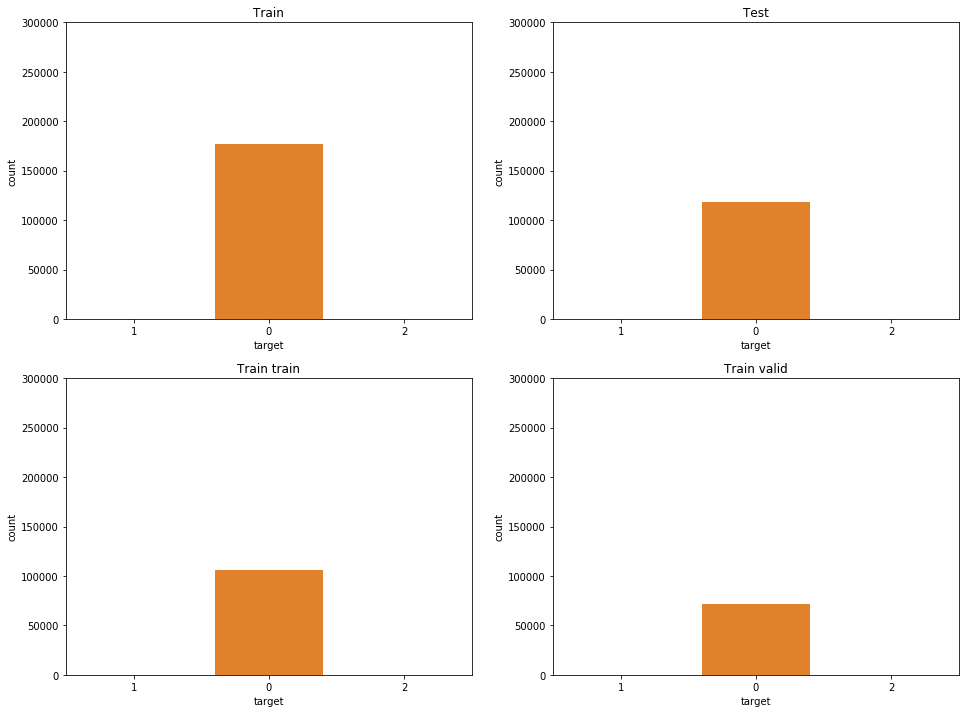

In [15]:
plt.figure(figsize=(16, 12))
y_max = 300000

plt.subplot(221)
plt.title('Train')
plt.ylim([0,y_max])
sns.countplot(data_train['target'], order=[1, 0, 2]);

plt.subplot(222)
plt.title('Test')
plt.ylim([0,y_max])
sns.countplot(data_test['target'], order=[1, 0, 2]);

plt.subplot(223)
plt.title('Train train')
plt.ylim([0,y_max])
sns.countplot(data_train['target'].iloc[:int(data_train.shape[0] * 0.7)], order=[1, 0, 2]);

plt.subplot(224)
plt.title('Train valid')
plt.ylim([0,y_max])
sns.countplot(data_train['target'].iloc[int(data_train.shape[0] * 0.7):], order=[1, 0, 2]);

In [16]:
data_test['target'].value_counts(normalize=True)

-1    0.644381
 0    0.355619
Name: target, dtype: float64

## Preparing train and test dataframes

In [17]:
X = data_train.drop(['target', 'datetime'], axis=1)
y = data_train['target']

X_test = data_test.drop(['target', 'datetime'], axis=1)
y_test = data_test['target']

del data_train
del data_test

In [18]:
y.unique()

array([-1,  0], dtype=int64)

In [19]:
sum(y == 0)
sum(y == -1)

177470

314190

In [20]:
y = y.replace({0:1})
y = y.replace({-1:0})

In [21]:
y.unique()

array([0, 1], dtype=int64)

In [22]:
sum(y == 1)
sum(y == 0)

177470

314190

# Funcs

## Evaluation func (for hyperparameters)

In [23]:
def lgb_train(max_depth,
             feature_fraction,
             bagging_fraction,
             lambda_l1,
             lambda_l2,
             num_leaves,
             min_child_samples,
             min_gain_to_split
            ):

    model_params = {'max_depth': int(max_depth),
                    'feature_fraction': feature_fraction,
                    'bagging_fraction': bagging_fraction,
                    'lambda_l1': lambda_l1,
                    'lambda_l2': lambda_l2,
                    'num_leaves': int(num_leaves),                
                    'min_child_samples': int(min_child_samples),
                    'min_gain_to_split': min_gain_to_split
                   }
    
    optim_params = {'num_boost_round': 10000,
                    'learning_rate': 0.01,
                    'early_stopping_rounds': 300,
                    'verbose_eval': 100
                   }


    task_params = {'objective': 'binary',
                   'num_class': 1,
                   'metric': 'auc'
                  }
    device_params = {'device': 'cpu',
#                       'gpu_platform_id': 0,
#                       'gpu_device_id': 0,
#                       'max_bin': 255,
#                       'num_threads': 6
                    }

    
    return training.lgb_train(X_res, pd.Series(y_res), train_part=0.7733253343318419, optim_params=optim_params, model_params=model_params, task_params=task_params, device_params=device_params)

In [24]:
def lgb_eval(max_depth,
             feature_fraction,
             bagging_fraction,
             lambda_l1,
             lambda_l2,
             num_leaves,
             min_child_samples,
             min_gain_to_split
            ):

    model_params = {'max_depth': int(max_depth),
                    'feature_fraction': feature_fraction,
                    'bagging_fraction': bagging_fraction,
                    'lambda_l1': lambda_l1,
                    'lambda_l2': lambda_l2,
                    'num_leaves': int(num_leaves),                
                    'min_child_samples': int(min_child_samples),
                    'min_gain_to_split': min_gain_to_split
                   }
    

    optim_params = {'num_boost_round': 200,
                    'learning_rate': 0.1,
                    'early_stopping_rounds': 50,
                    'verbose_eval': 0
                   }

    task_params = {'objective': 'binary',
                   'num_class': 1,
                   'metric': 'auc'
                  }
    
    device_params = {'device': 'cpu',
#                       'gpu_platform_id': 0,
#                       'gpu_device_id': 0,
#                       'max_bin': 63,
#                       'num_threads': 6
                    }
    
    return training.lgb_train(X, pd.Series(y), optim_params=optim_params, model_params=model_params, task_params=task_params, device_params=device_params, tuning=True)

## Hyperparam tuning func (Bayesian opt)

In [25]:
def param_tuning(init_points, num_iter, **args):
    
    lgbBO = BayesianOptimization(lgb_eval, {'max_depth': (7, 14),
                                            'feature_fraction': (0.4, 1),
                                            'bagging_fraction': (0.4, 1),
                                            'lambda_l1': (0.0, 0.1),
                                            'lambda_l2': (0.0, 0.1),
                                            'num_leaves': (128, 12000),
                                            'min_child_samples': (1000, 10000),
                                            'min_gain_to_split': (0, 0),
                                            })
    
    lgbBO.maximize(init_points=init_points, n_iter=num_iter, **args)
    return lgbBO

## Hyperparam tuning

In [26]:
import warnings
warnings.simplefilter("ignore")

In [27]:
X.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X.columns]

In [28]:
X_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_test.columns]

In [29]:
%%time
bayesian_tun = param_tuning(3, 5)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_ga... | num_le... |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7256   |  0.7996   |  0.7737   |  0.02391  |  0.000345 |  13.9     |  9.666e+0 |  0.0      |  8.809e+0 |
|  2        |  0.7251   |  0.8329   |  0.9135   |  0.09003  |  0.08277  |  8.348    |  1.164e+0 |  0.0      |  6.256e+0 |
|  3        |  0.7254   |  0.681    |  0.501    |  0.08807  |  0.06305  |  8.81     |  7.712e+0 |  0.0      |  9.307e+0 |
|  4        |  0.725    |  0.6161   |  0.9166   |  0.09562  |  0.03249  |  8.055    |  9.991e+0 |  0.0      |  131.7    |
|  5        |  0.7241   |  0.7571   |  0.4617   |  0.0548   |  0.0216   |  12.74    |  1.007e+0 |  0.0      |  1.198e+0 |
|  6        |  0.7253   |  0.4837   |  0.802    |  0.04634  |  0.046    |  7.826    |  1.014e+0 |  0.0      |  136.5    |
|  7        |  0.7254   

In [30]:
params = bayesian_tun.max['params']

In [31]:
params

{'bagging_fraction': 0.7996499294524465,
 'feature_fraction': 0.773661254808264,
 'lambda_l1': 0.02390945461267915,
 'lambda_l2': 0.00034551671852811605,
 'max_depth': 13.900026740021179,
 'min_child_samples': 9666.123130671069,
 'min_gain_to_split': 0.0,
 'num_leaves': 8809.281093961652}

# Oversampling

In [32]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [34]:
point = int(len(X) * 0.7)

In [35]:
X_res_1, y_res_1 = sm.fit_resample(X.iloc[:point, :], y[:point])
print('Resampled dataset shape %s' % Counter(y_res_1))

Resampled dataset shape Counter({0: 238205, 1: 238205})


In [36]:
X_res = pd.DataFrame(X_res_1, columns=X.columns)

In [37]:
X_res = X_res.append(X.iloc[point:, :])
y_res = pd.Series(y_res_1).append(y[point:])

In [38]:
len(X_res_1) / len(X_res)

0.7635901447008213

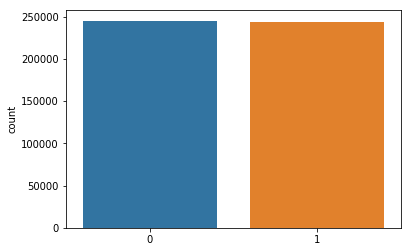

In [39]:
sns.countplot(y_res[:int(len(y_res) * 0.782504)])

In [40]:
y_res.value_counts(normalize=True)

0    0.503584
1    0.496416
dtype: float64

# Model training

In [41]:
params = {'bagging_fraction': 0.612597911312686,
 'feature_fraction': 0.5623226633160302,
 'lambda_l1': 0.00047107687613179294,
 'lambda_l2': 0.01359749662288301,
 'max_depth': 14.220787633196979,
 'min_child_samples': 1103.1080006183051,
 'min_gain_to_split': 0.0,
 'num_leaves': 12550.527293636744}

In [42]:
params

{'bagging_fraction': 0.612597911312686,
 'feature_fraction': 0.5623226633160302,
 'lambda_l1': 0.00047107687613179294,
 'lambda_l2': 0.01359749662288301,
 'max_depth': 14.220787633196979,
 'min_child_samples': 1103.1080006183051,
 'min_gain_to_split': 0.0,
 'num_leaves': 12550.527293636744}

In [43]:
params_my = params
params_my['feature_fraction'] = 1
#params_my['num_leaves'] = 17000
#params_my['min_child_samples'] = 280

In [54]:
%%time
model = lgb_train(**params)

Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.82586	valid's auc: 0.745103
[200]	train's auc: 0.857873	valid's auc: 0.749203
[300]	train's auc: 0.878252	valid's auc: 0.750102
[400]	train's auc: 0.890579	valid's auc: 0.751005
[500]	train's auc: 0.899693	valid's auc: 0.750981
[600]	train's auc: 0.905852	valid's auc: 0.75104
[700]	train's auc: 0.910245	valid's auc: 0.750951
[800]	train's auc: 0.914017	valid's auc: 0.75062
[900]	train's auc: 0.917665	valid's auc: 0.750023
Early stopping, best iteration is:
[641]	train's auc: 0.907609	valid's auc: 0.751107
Wall time: 4min 15s


In [45]:
model

In [53]:
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier


In [51]:
clf2 = RandomForestClassifier(random_state=1)
clf3 = LGBMClassifier(**params)
lr = LogisticRegression()

Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.82586	valid's auc: 0.745103
[200]	train's auc: 0.857873	valid's auc: 0.749203
[300]	train's auc: 0.878252	valid's auc: 0.750102
[400]	train's auc: 0.890579	valid's auc: 0.751005
[500]	train's auc: 0.899693	valid's auc: 0.750981
[600]	train's auc: 0.905852	valid's auc: 0.75104
[700]	train's auc: 0.910245	valid's auc: 0.750951
[800]	train's auc: 0.914017	valid's auc: 0.75062
[900]	train's auc: 0.917665	valid's auc: 0.750023
Early stopping, best iteration is:
[641]	train's auc: 0.907609	valid's auc: 0.751107


# Results

Checking results On full test dataset All features result \ Test data part = 199923 / 199923 = 100.0% \ Accuracy = 0.5715 \ Precision = 0.5643 \ Recall = 0.5715

Real classes where 0 was predicted: \ 0 63.341281 \ 2 25.887800 \ 1 10.770919 \ Name: y, dtype: float64 \ 0 50210 \ 2 20521 \ 1 8538 \ Name: y, dtype: int64

Real classes where 1 was predicted: \ 1 47.555919 \ 2 36.158583 \ 0 16.285499 \ Name: y, dtype: float64 \ 1 7569 \ 2 5755 \ 0 2592 \ Name: y, dtype: int64

Real classes where 2 was predicted: \ 2 53.925032 \ 0 25.009070 \ 1 21.065898 \ Name: y, dtype: float64 \ 2 56480 \ 0 26194 \ 1 22064 \ Name: y, dtype: int64